In [40]:
import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import PandasTools
import zipfile
from io import BytesIO

import selfies as sf




# 1. SMILES to molecular structure
print molecule structures from generated data

In [41]:
#smiles = pd.read_csv('../checkpoints/ZINC_vae_done/vae_generated.csv')
smiles = pd.read_csv('../../NewMoses_results/ZINC_vae_20240515/vae_generated.csv')
smiles.head()

FileNotFoundError: [Errno 2] No such file or directory: '../../NewMoses_results/ZINC_vae_20240515/vae_generated.csv'

In [ ]:
smiles['ROMol'] = smiles['SMILES'].apply(Chem.MolFromSmiles)

In [ ]:
smiles.head()

In [ ]:
display(PandasTools.FrameToGridImage(smiles, column='ROMol', legendsCol='SMILES', molsPerRow=5))

In [ ]:
smiles

# 2. Latent Space Visualization

In [ ]:
import sys
sys.path.append("..")
import moses
from moses.vae import VAE
from moses.vae_property import VAEPROPERTY
from moses.utils import CharVocab, StringDataset, SELFIESVocab
from moses.vae.trainer import VAETrainer
from moses.vae_property.trainer import VAEPROPERTYTrainer 

from moses.metrics import QED, SA, logP
from moses.utils import get_mol

## 2.1. Calling model

### Functions for calling VAE models and forward encoding (not vae-prop models)

In [ ]:
def get_vae_model(folder_path, config_file, model_file):
    config = torch.load(f'{folder_path}{config_file}')

    train = moses.get_dataset('train', config)
    vocab = CharVocab.from_data(train)
    vocab.vectors = torch.eye(len(vocab.c2i))

    model_path = f'{folder_path}{model_file}'

    model = VAE(vocab, config)
    model.load_state_dict(torch.load(model_path))
    return train, config, model

    

def get_sample(train, prop, size=50000):
    '''
    [Input]
    train: 
    prop: list of properties to calculate. 'QED', 'logP', 'SA' are available.
    '''
    
    size = size
    np.random.seed(0)
    rand_indices = np.random.choice(train.shape[0], size, replace=False)
    sample = train[rand_indices]

    if prop is None:
        return sample
    
    sample_mol = list(map(get_mol, sample))
    if 'QED' in prop:
        sample_qed = list(map(QED, sample_mol))
    else:
        sample_qed = None
    if 'logP' in prop:
        sample_logP = list(map(logP, sample_mol))
    else:
        sample_logP = None
    if 'SA' in prop:
        sample_sa = list(map(SA, sample_mol))
    else:
        sample_sa = None

    sample_prop = pd.DataFrame({'QED': sample_qed, 'logP': sample_logP, 'SA': sample_sa})
    return sample, sample_prop

def get_Z(config, model, sample):
    trainer = VAETrainer(config)
    sample_loader = trainer.get_dataloader(model, sample, shuffle=False)

    Z = []

    for step, batch in enumerate(sample_loader):
        input_batch = tuple(data.to(model.device) for data in batch)
        z, _ = model.forward_encoder(input_batch)
        Z.extend(z.detach().cpu().numpy())

    Z = np.array(Z)

    return Z

### appendix: step by step of calling the models and samples

In [ ]:
#config = torch.load('../checkpoints/ZINC_vae_done/vae_config.pt')
folder_path = "../NewMoses_results/ZINC_vae_property_20240522_051929"
config = torch.load(f'{folder_path}/vae_property_config.pt')

# vocab = torch.load('../checkpoints/ZINC_vae_done/vae_vocab.pt')
train = pd.DataFrame(moses.get_dataset('train', config)[:50000], columns=['SMILES', 'logP', 'QED', 'SA'])


In [ ]:
print(config.use_selfies)

False


In [ ]:
train

,SMILES,logP,QED,SA
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,1.6807,0.896898,3.812618
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,3.7293,0.862259,2.936327
2,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,2.29702,0.701022,2.663795
3,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,-2.2131,0.646083,2.989161
4,CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,0.8071,0.853457,3.05575
...,...,...,...,...
49995,O=C(CC(O)(C(F)(F)F)C(F)(F)F)c1ccco1,2.7081,0.681779,2.784777
49996,CC(=O)c1ccc(C(=O)CC(O)(C(F)(F)F)C(F)(F)F)cc1,3.3177,0.681363,2.41245
49997,NC(=O)n1ccc(CC(O)(C(F)(F)F)C(F)(F)F)n1,1.2081,0.803519,3.239567
49998,c1ccc(CC(Cc2ccccc2)NC2=NCCO2)cc1,2.8162,0.913436,2.322958


In [ ]:
vocab = CharVocab.from_data(train['SMILES'])
vocab.vectors = torch.eye(len(vocab.c2i))

{'4', '[', 'C', ']', '-', '(', 'F', 'S', '=', 's', 'O', 'c', '#', '2', 'H', 'l', 'N', '1', 'B', '5', '3', ')', 'o', 'n', 'r'}


In [ ]:
#model_path = '../checkpoints/ZINC_vae_done/vae_model_080.pt'
model_path = f'{folder_path}/vae_model_080.pt'

model = VAE(vocab, config)
model.load_state_dict(torch.load(model_path))

* sample size = 50,000

In [ ]:
size = 50000
np.random.seed(0)
rand_indices = np.random.choice(train.shape[0], size, replace=False)
sample = train[rand_indices]

In [ ]:
sample_mol = list(map(get_mol, sample))
sample_qed = list(map(QED, sample_mol))
sample_logP = list(map(logP, sample_mol))
sample_sa = list(map(SA, sample_mol))

In [ ]:
trainer = VAETrainer(config)
sample_loader = trainer.get_dataloader(model, sample, shuffle=False)

## 2.2 Plotting embedding space function

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [ ]:
def plot_emb(Z_vis, prop, prop_type, dataset, type):
    df = pd.DataFrame(np.transpose((Z_vis[:,0],Z_vis[:,1])))
    df.columns = ['x','y']

    if len(prop_type) == 1:
        df['prop']=prop[prop_type[0]]

        plt.figure(figsize=(12, 8))
        plt.scatter(x=df['x'], y=df['y'], c=df['prop'],
                    cmap= 'viridis', marker='.',
                    s=10,alpha=0.5, edgecolors='none')
        plt.title(f'{type} of latent space colored by {prop_type} of dataset {dataset}')
        plt.colorbar()

        plt.tight_layout()
        plt.show()
        return 

    if len(prop_type) == 2:
        fig, axs = plt.subplots(1,2, figsize=(12, 5))
        
    elif len(prop_type) == 3:
        fig, axs = plt.subplots(1,3, figsize=(18, 5))

    for i in range(len(prop_type)):
        df[f'prop{i}'] = prop[prop_type[i]]
        scatter = axs[i].scatter(x=df['x'], y=df['y'], c=df[f'prop{i}'],
                                cmap= 'viridis', marker='.',
                                s=10,alpha=0.5, edgecolors='none')
        axs[i].set_title(f'{type} of by {prop_type[i]} of dataset {dataset}')
        cbar = fig.colorbar(scatter, ax=axs[i])
        cbar.set_label(prop_type[i])

    plt.tight_layout()
    plt.show()


In [ ]:
def calc_emb(Z, prop, prop_type, type=['PCA'], dataset='ZINC', plot=True, n_componenets=2):
    '''
    [Input]
    Z: latent space, numpy array of shape (n_samples, d_embedding)
    prop: property to color the latent space, dataframe of shape (n_samples, n_properties) with columns 'QED', 'logP', 'SA'
    prop_type: list containing the type of property to be colored. 'QED', 'logP', 'SA' are available.
    type: str, 'PCA' or 'TSNE'
    dataset: str, name of the dataset to be written in the title of the plot
    plot: bool, whether to plot the latent space or not
    n_components: int, number of components to reduce the latent space to
    '''
    print("---------------- Z -----------------")
    Z = np.array([np.array(z) for z in Z])
    print(Z.shape)

    print("---------------- prop -----------------")
    print(prop.shape)

    # do pca and normalize
    if type == 'PCA':
        vis = PCA(n_components=2)
        Z_vis = vis.fit_transform(Z)
        Z_vis = MinMaxScaler().fit_transform(Z_vis)

        print(f'explained variance ratio: {vis.explained_variance_ratio_}')
    else:
        Z_vis = TSNE(n_components=2).fit_transform(Z)
        Z_vis = MinMaxScaler().fit_transform(Z_vis)

    if plot:
        plot_emb(Z_vis, prop, prop_type, dataset, type)

   
    return 

## 2.3. Implmentation

### ZINC VAE

In [ ]:
folder_path = '../../NewMoses_results/ZINC_vae_20240515/'
config_file = 'vae_config.pt'
model_file = 'vae_model_080.pt'

train, config, model = get_vae_model(folder_path, config_file, model_file)
sample, sample_prop = get_sample(train, ['QED', 'logP', 'SA'])
Z = get_Z(config, model, sample)

In [ ]:
calc_emb(Z, sample_prop, prop_type=['QED', 'logP', 'SA'], type='PCA')

In [ ]:
calc_emb(Z, sample_prop, prop_type=['QED', 'logP', 'SA'], type='TSNE')

### QM9 VAE

In [ ]:
folder_path = '../../NewMoses_results/QM9_vae_20240515/'
config_file = 'vae_config.pt'
model_file = 'vae_model_080.pt'

train_qm9, config_qm9, model_qm9 = get_vae_model(folder_path, config_file, model_file)
sample_qm9, sample_prop_qm9 = get_sample(train_qm9, ['QED', 'logP', 'SA'])
Z_qm9 = get_Z(config, model, sample)

In [ ]:
calc_emb(Z_qm9, sample_prop_qm9, prop_type=['QED', 'logP', 'SA'], type='PCA', dataset='QM9')

In [ ]:
calc_emb(Z_qm9, sample_prop_qm9, prop_type=['QED', 'logP', 'SA'], type='TSNE')

### SELFIES ZINC
Check if it wokrs. Might not be working --> MODIFY THE CODE

In [ ]:
## SELFIES ZINC
folder_path = '../../NewMoses_results/ZINC_SELFIES_vae_20240522_135605/'
config_file = 'vae_config.pt'
model_file = 'vae_model_080.pt'

config_zinc_self = torch.load(f'{folder_path}{config_file}')

file_path = '../moses/dataset/data/ZINC/train.zip'
with zipfile.ZipFile(file_path, 'r') as zip_ref:    
        file = 'train.csv'
        with zip_ref.open(file) as file:
            # Read the CSV file into a pandas DataFrame
            df= pd.read_csv(BytesIO(file.read()), header=0)
            train_zinc_self = df['SELFIES'].values

vocab_zinc_self = CharVocab.from_data(train_zinc_self)
vocab_zinc_self.vectors = torch.eye(len(vocab_zinc_self.c2i))

model_path = f'{folder_path}{model_file}'


In [ ]:
model_zinc_self = VAE(vocab_zinc_self, config_zinc_self)
model_zinc_self.load_state_dict(torch.load(model_path))

sample_zinc_self, sample_prop_zinc_self = get_sample(train_zinc_self, ['QED'])
Z_zinc_self = get_Z(config_zinc_self, model_zinc_self, sample_zinc_self)

In [ ]:
calc_emb(Z_zinc_self, sample_prop_zinc_self, prop_type=['QED', 'logP', 'SA'], type='PCA')

### SELFIES PROP ZINC
Doesn't work with the functions. Used step by step approach

In [ ]:
folder_path = '../NewMoses_results/ZINC_vae_property_20240528_051033/'
config_file = 'vae_property_config.pt'
model_file = 'vae_property_model_080.pt'
#config = torch.load('../checkpoints/ZINC_vae_done/vae_config.pt')
config_prp = torch.load(f'{folder_path}{config_file}')

In [ ]:
config_prp.use_selfies

True

In [ ]:
file_path = '../moses/dataset/data/ZINC/train.zip'
with zipfile.ZipFile(file_path, 'r') as zip_ref:    
        file = 'train.csv'
        with zip_ref.open(file) as file:
            # Read the CSV file into a pandas DataFrame
            df= pd.read_csv(BytesIO(file.read()), header=0)
            cols = ['logP', 'qed', 'SAS']
            cols.insert(0, 'SELFIES' if config_prp.use_selfies else 'SMILES')
            train_prp = df[cols].values


In [ ]:
if config_prp.use_selfies:
    train_prp_vocab = df['SELFIES'].values
else:
    train_prp_vacab = df['SMILES'].values

In [ ]:
vocab_prp = SELFIESVocab.from_data(train_prp_vocab, use_selfies=config_prp.use_selfies)
vocab_prp.vectors = torch.eye(len(vocab_prp.c2i))

------- Using SELFIES: True -------
{'=S', '=N', 'C', '#Branch1', '=Branch2', 'F', 'O', '#N', 'Branch2', 'H', '=O', '=Branch1', '#Branch2', 'P', 'S', '#C', 'Branch1', 'Cl', '=Ring2', 'Ring1', 'Ring2', '=Ring1', '=C', 'N', 'Br', 'NH1'}


In [ ]:
#model_path = '../checkpoints/ZINC_vae_done/vae_model_080.pt'
model_path = f'{folder_path}{model_file}'

model_prp = VAEPROPERTY(vocab_prp, config_prp)
model_prp.load_state_dict(torch.load(model_path))

<All keys matched successfully>

* sample size = 50,000

In [ ]:
size = 50000
np.random.seed(0)
rand_indices = np.random.choice(train_prp_vocab.shape[0], size, replace=False)
sample_prp = train_prp[rand_indices]

In [ ]:
sample_prp.shape

(50000, 4)

In [ ]:
# use rdkit to transform selfies to smiles
if config_prp.use_selfies:
    sample_selfies_prp = [sf.decoder(s) for s in sample_prp[:, 0]]


In [ ]:
sample_prp[:, 1:].shape

(50000, 3)

In [ ]:
config_prp.n_batch = 50000

In [ ]:
trainer_prp = VAEPROPERTYTrainer(config_prp)
sample_loader = trainer_prp.get_dataloader(model_prp, sample_prp, shuffle=False)

In [ ]:
model_prp.eval()

VAEPROPERTY(
  (x_emb): Embedding(30, 30, padding_idx=28)
  (encoder_rnn): GRU(30, 256, batch_first=True)
  (q_mu): Linear(in_features=256, out_features=128, bias=True)
  (q_logvar): Linear(in_features=256, out_features=128, bias=True)
  (decoder_rnn): GRU(158, 512, num_layers=3, batch_first=True)
  (decoder_lat): Linear(in_features=128, out_features=512, bias=True)
  (decoder_fc): Linear(in_features=512, out_features=30, bias=True)
  (predictor_layers): Sequential(
    (0): Linear(in_features=128, out_features=67, bias=True)
    (1): Linear(in_features=67, out_features=66, bias=True)
    (2): Tanh()
    (3): BatchNorm1d(66, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=66, out_features=65, bias=True)
    (5): Tanh()
    (6): BatchNorm1d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (predictor_fc): Linear(in_features=65, out_features=3, bias=True)
  (encoder): ModuleList(
    (0): GRU(30, 256, batch_first=True)
 

In [ ]:
#batch[0] : 50000 * 52
#batch[1] : list of length 1 with tensor shape (50000, 3)
for step, batch in enumerate(sample_loader):
    
    data = batch[0]
    prop = batch[1][0]

    

    print(len(data))
    print(len(prop))

    
    break

50000
50000


/Users/jonghopark/Desktop/Postech/U_of_T/Coding/Internship Project/molecular-vae/NewMoses/notebooks/../moses/vae_property/trainer.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  y_tensors = [torch.tensor(y_sorted, dtype=torch.float32, device=device)]


In [ ]:
data = batch[0]
prop = batch[1][0]

In [ ]:
prop

tensor([[3.5355, 0.6897, 5.2904],
        [4.0492, 0.8235, 3.1394],
        [2.6194, 0.7855, 3.1641],
        ...,
        [2.7039, 0.8280, 2.1133],
        [2.6152, 0.7797, 2.5079],
        [2.1888, 0.7680, 2.7099]])

In [ ]:
prop_df = pd.DataFrame(prop, columns=['logP', 'QED', 'SA'])

In [ ]:
data_df = pd.DataFrame(([vocab_prp.ids2string(point.detach().cpu().numpy())] for point in data), columns=["data"])

In [ ]:
data_df.head()

,data
0,[C][C][Branch1][C][C][C][C][C][C][Branch1][C][...
1,[C][C][=N][N][Branch1][C][C][C][=N][C][Branch1...
2,[C][C][C][=C][Branch1][C][C][N][N][=C][C][Bran...
3,[C][C][N][=C][Branch1][C][C][N][Branch2][Ring2...
4,[C][C][C][=C][Branch1][C][C][N][Branch2][Ring2...


In [ ]:
prop_df

,logP,QED,SA
0,3.53550,0.689672,5.290425
1,4.04922,0.823506,3.139359
2,2.61944,0.785452,3.164137
3,2.40324,0.838778,3.188758
4,3.68894,0.707873,2.177726
...,...,...,...
49995,2.55580,0.849747,2.169917
49996,3.17960,0.767539,2.669538
49997,2.70390,0.828015,2.113346
49998,2.61520,0.779739,2.507874


In [ ]:
mu, logvar, z, _ = model_prp.forward_encoder(data)

In [ ]:
mu_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in mu], columns=["mu"])
logvar_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in logvar], columns=["logvar"])
z_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in z], columns=["z"])

In [ ]:
whole_latent_data = pd.concat([data_df, mu_df, logvar_df, z_df, prop_df], axis=1)

---------------- Z -----------------
(50000, 128)
---------------- prop -----------------
(50000, 3)
explained variance ratio: [0.01076458 0.00966568]


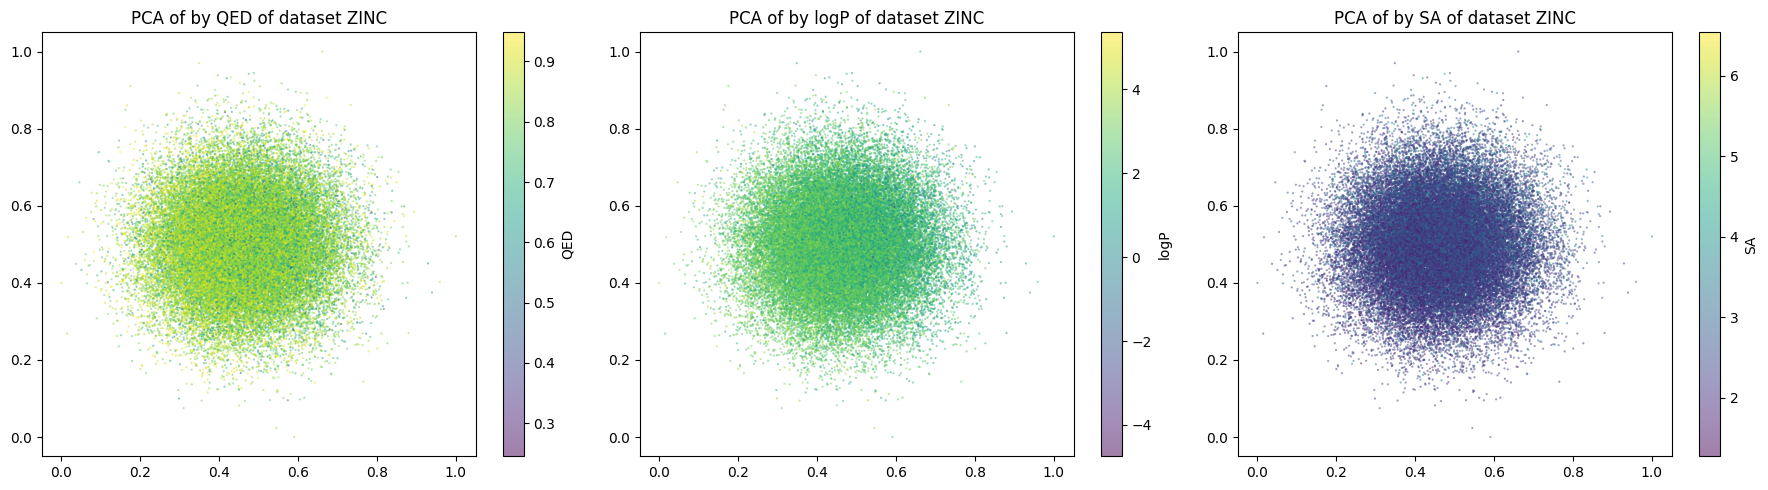

In [ ]:
calc_emb(whole_latent_data['z'].values, prop=whole_latent_data[['logP', 'QED', 'SA']], prop_type=['QED', 'logP', 'SA'], type='PCA', dataset='ZINC')

In [ ]:
whole_latent_data

,data,mu,logvar,z,logP,QED,SA
0,[C][C][Branch1][C][C][C][C][C][C][Branch1][C][...,"[0.03904126, 0.054448195, -0.0038935198, 2.195...","[-0.029872973, -0.030340943, -0.050990555, -7....","[0.01951417, 0.05942897, -0.6873364, 2.1770637...",3.53550,0.689672,5.290425
1,[C][C][=N][N][Branch1][C][C][C][=N][C][Branch1...,"[-0.0538008, -0.022801446, 0.068555735, 0.8746...","[-0.02396229, -0.013087352, -0.023507357, -7.5...","[-2.6610525, -0.9655211, 1.6625508, 0.8754231,...",4.04922,0.823506,3.139359
2,[C][C][C][=C][Branch1][C][C][N][N][=C][C][Bran...,"[-0.036656417, 0.045198087, -0.0326275, -0.799...","[-0.024600118, -0.020833546, -0.016681656, -7....","[-0.56097615, -0.23542279, 0.4594812, -0.79648...",2.61944,0.785452,3.164137
3,[C][C][N][=C][Branch1][C][C][N][Branch2][Ring2...,"[-0.06252841, 0.040386297, 0.12026331, 1.01132...","[-0.015464575, -0.00603069, -0.0076016914, -7....","[-0.06892243, 0.10519941, -0.3359178, 1.026771...",2.40324,0.838778,3.188758
4,[C][C][C][=C][Branch1][C][C][N][Branch2][Ring2...,"[-0.14229195, 0.022089787, -0.048887838, -0.61...","[-0.018854707, -0.011942884, -0.008654743, -6....","[-0.66296697, -0.021960914, 1.8859369, -0.5528...",3.68894,0.707873,2.177726
...,...,...,...,...,...,...,...
49995,[C][O][C][C][N][C][=N][C][=C][Branch1][C][Br][...,"[0.024414195, -0.049731757, 0.025487961, -1.88...","[-0.025702732, -0.020811265, -0.009850688, -5....","[-0.72089064, 0.18966517, -0.6240594, -1.82424...",2.55580,0.849747,2.169917
49996,[Br][C][=C][C][=C][Branch1][=Branch1][C][=C][R...,"[0.038941145, -0.025672778, 0.035539012, -1.00...","[-0.0142564075, -0.02554894, -0.027754473, -5....","[-0.3613861, 0.7406778, -0.008767258, -1.00816...",3.17960,0.767539,2.669538
49997,[O][C][C][=C][C][Branch1][C][Br][=C][C][Branch...,"[0.010314068, -0.004551038, 0.0726245, -0.2372...","[-0.029625837, -0.015843017, -0.020623017, -6....","[-1.7411618, -0.36553884, -1.3101956, -0.22211...",2.70390,0.828015,2.113346
49998,[C][O][C][=C][Branch1][C][Br][C][=N][C][=C][Ri...,"[0.024006031, -0.105899006, 0.025280599, -1.10...","[-0.033710435, -0.013264916, -0.029434154, -5....","[0.7336177, 0.080832854, 0.2981416, -1.1863782...",2.61520,0.779739,2.507874


In [ ]:
whole_latent_data['euclid_dist_mu_z'] = [np.sqrt(sum((mu - z)**2)) for mu,z in zip(whole_latent_data['mu'], whole_latent_data['z'])]

In [ ]:
diff = whole_latent_data['mu'][0]-whole_latent_data['z'][0]

max(diff), min(diff)

(2.7501636, -2.1701336)

In [ ]:
generated_data = model_prp.sample(n_batch=50000, z = z, test=False)

In [ ]:
whole_latent_data['generated'] = generated_data

In [ ]:
whole_latent_data

,data,mu,logvar,z,logP,QED,SA,euclid_dist_mu_z,generated
0,[C][C][Branch1][C][C][C][C][C][C][Branch1][C][...,"[0.03904126, 0.054448195, -0.0038935198, 2.195...","[-0.029872973, -0.030340943, -0.050990555, -7....","[0.01951417, 0.05942897, -0.6873364, 2.1770637...",3.53550,0.689672,5.290425,10.026725,[C][C][Branch1][C][C][C][C][C][C][Branch1][C][...
1,[C][C][=N][N][Branch1][C][C][C][=N][C][Branch1...,"[-0.0538008, -0.022801446, 0.068555735, 0.8746...","[-0.02396229, -0.013087352, -0.023507357, -7.5...","[-2.6610525, -0.9655211, 1.6625508, 0.8754231,...",4.04922,0.823506,3.139359,10.520553,[C][C][N][=C][Branch1][C][C][N][Branch2][Ring1...
2,[C][C][C][=C][Branch1][C][C][N][N][=C][C][Bran...,"[-0.036656417, 0.045198087, -0.0326275, -0.799...","[-0.024600118, -0.020833546, -0.016681656, -7....","[-0.56097615, -0.23542279, 0.4594812, -0.79648...",2.61944,0.785452,3.164137,9.909309,[C][C][C][=C][Branch1][C][C][N][N][=C][C][Bran...
3,[C][C][N][=C][Branch1][C][C][N][Branch2][Ring2...,"[-0.06252841, 0.040386297, 0.12026331, 1.01132...","[-0.015464575, -0.00603069, -0.0076016914, -7....","[-0.06892243, 0.10519941, -0.3359178, 1.026771...",2.40324,0.838778,3.188758,10.103575,[C][C][N][=C][Branch2][Ring1][#Branch1][C][C][...
4,[C][C][C][=C][Branch1][C][C][N][Branch2][Ring2...,"[-0.14229195, 0.022089787, -0.048887838, -0.61...","[-0.018854707, -0.011942884, -0.008654743, -6....","[-0.66296697, -0.021960914, 1.8859369, -0.5528...",3.68894,0.707873,2.177726,9.635033,[C][C][C][=C][Branch1][C][C][N][Branch2][Ring2...
...,...,...,...,...,...,...,...,...,...
49995,[C][O][C][C][N][C][=N][C][=C][Branch1][C][Br][...,"[0.024414195, -0.049731757, 0.025487961, -1.88...","[-0.025702732, -0.020811265, -0.009850688, -5....","[-0.72089064, 0.18966517, -0.6240594, -1.82424...",2.55580,0.849747,2.169917,10.308501,[C][O][C][C][N][C][=N][C][=C][Branch1][C][Br][...
49996,[Br][C][=C][C][=C][Branch1][=Branch1][C][=C][R...,"[0.038941145, -0.025672778, 0.035539012, -1.00...","[-0.0142564075, -0.02554894, -0.027754473, -5....","[-0.3613861, 0.7406778, -0.008767258, -1.00816...",3.17960,0.767539,2.669538,9.948886,[Br][C][=C][C][=C][Branch1][#Branch1][N][C][C]...
49997,[O][C][C][=C][C][Branch1][C][Br][=C][C][Branch...,"[0.010314068, -0.004551038, 0.0726245, -0.2372...","[-0.029625837, -0.015843017, -0.020623017, -6....","[-1.7411618, -0.36553884, -1.3101956, -0.22211...",2.70390,0.828015,2.113346,10.604800,[O][C][C][=C][C][Branch1][C][Br][=C][C][Branch...
49998,[C][O][C][=C][Branch1][C][Br][C][=N][C][=C][Ri...,"[0.024006031, -0.105899006, 0.025280599, -1.10...","[-0.033710435, -0.013264916, -0.029434154, -5....","[0.7336177, 0.080832854, 0.2981416, -1.1863782...",2.61520,0.779739,2.507874,11.266191,[C][O][C][=C][C][Branch1][C][N][=C][C][=C][Rin...


In [ ]:
whole_latent_data['generated_smiles'] = [sf.decoder(s) for s in whole_latent_data['generated']]
whole_latent_data['original_smiles'] = [sf.decoder(s) for s in whole_latent_data['data']]

### SELFIES ZINC PROP interpolation

To be modified

In [ ]:
sample_prp.shape

(50000, 4)

In [ ]:
sample_prp_df = pd.DataFrame(sample_prp, columns=['SELFIES', 'logP', 'QED', 'SA'])
sample_prp_df = sample_prp_df[['SELFIES', 'QED', 'logP', 'SA']]
sample_prp_df = sample_prp_df[:2048]
sample_prp_df.head()

,SELFIES,QED,logP,SA
0,[C][O][C][C][C][C][S][C][=N][C][=C][Branch1][B...,0.47744,1.7773,2.629071
1,[C][C][=C][S][C][=Branch1][C][=O][N][Ring1][=B...,0.920477,2.23052,2.108029
2,[C][C][=C][C][=C][C][Branch2][Ring1][=Branch1]...,0.916358,3.64622,2.182469
3,[C][C][=C][C][=C][Branch2][Ring1][Branch2][C][...,0.925364,2.61282,2.260791
4,[C][N][C][Branch1][N][C][=C][C][=C][C][Branch1...,0.682311,3.1007,2.308511


In [ ]:
trainer_prp = VAEPROPERTYTrainer(config_prp)
sample_loader = trainer_prp.get_dataloader(model_prp, sample_prp, shuffle=False)

for i, batch in enumerate(sample_loader):
    mu, z, _ = model_prp.forward_encoder(batch[0])
    break

In [ ]:
# interps : mu to decode
interps = [mu for mu in sample_prp_df['mu'].values]
interps = np.array(interps)
interps_torch = torch.from_numpy(interps)
interps_torch = torch.tensor(interps_torch, dtype=torch.float32)
model_prp.eval()
print(interps_torch.shape)
#sampled, new_x = model.sample(n, z=torch.from_numpy(np.zeros((8, 128), dtype=np.float32)), test=True) 
sampled = model_prp.sample(2048, z=interps_torch, temp=1.0, test=True)
sample_prp_df['pred SELFIES'] = sampled

/var/folders/q2/tgsjy6xn07v0rbjsxs660bkh0000gn/T/ipykernel_2032/3494722909.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interps_torch = torch.tensor(interps_torch, dtype=torch.float32)


torch.Size([2048, 128])


In [ ]:
# sample_prp_df['pred Romol'] = sample_prp_df['pred SMILES'].apply(Chem.MolFromSmiles)
sample_prp_df.head()

,SELFIES,QED,logP,SA,mu,z,pred SELFIES
0,[C][O][C][C][C][C][S][C][=N][C][=C][Branch1][B...,0.47744,1.7773,2.629071,"[-0.14229194819927216, 0.02208978682756424, -0...","[0.3020328879356384, -0.6351827383041382, 1.08...",[C][C][C][=C][Branch1][C][C][N][Branch2][Ring2...
1,[C][C][=C][S][C][=Branch1][C][=O][N][Ring1][=B...,0.920477,2.23052,2.108029,"[-0.07301078736782074, 0.033088088035583496, -...","[2.3705832958221436, 0.2341538816690445, -3.42...",[C][C][=C][C][=C][Branch2][Ring1][P][C][=C][C]...
2,[C][C][=C][C][=C][C][Branch2][Ring1][=Branch1]...,0.916358,3.64622,2.182469,"[0.06424613296985626, 0.05163007602095604, 0.0...","[0.13480684161186218, 0.6293966174125671, -1.0...",[C][C][=C][N][C][=C][Branch2][Ring1][=N][C][=B...
3,[C][C][=C][C][=C][Branch2][Ring1][Branch2][C][...,0.925364,2.61282,2.260791,"[0.16553343832492828, 0.06416196376085281, 0.0...","[0.05098339915275574, 0.21513351798057556, -1....",[C][C][O][C][=Branch1][C][=O][N][C][C][N][Bran...
4,[C][N][C][Branch1][N][C][=C][C][=C][C][Branch1...,0.682311,3.1007,2.308511,"[-0.08482447266578674, 0.0780971571803093, 0.1...","[1.4220465421676636, -0.29553622007369995, 0.5...",[C][C][N][C][=C][Branch2][Ring1][=C][C][=C][C]...


## Add similiarity measures to the whole_latent_data

In [57]:
def sampling_for_fixed_single_mu(model, mu, logvar, n_samples):
    """sampling for each mu value.

    Args:
        model (_type_): vae model
        mu (torch.Tensor): vector that has dimension with (latent_dim,)
        logvar (torch.Tensor): vector contains the diagonal element of log of variance matrix
        n_samples (int): number of samples to be sampled from single mu
    """
    z = np.random.normal(mu, np.exp(0.5*logvar), (n_samples, mu.shape[0]))
    z_values = torch.tensor(z, dtype=torch.float32)
    z_values = z_values.to(model.device)

    sampled = model.sample(n_samples, z=z_values, temp=1.0, test=True) #test is True, the final output is obtained from argmax.

    return z_values, sampled


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

def plot_mol(df, col):
    tmp = df.copy(deep=True)
    tmp['ROMol'] = tmp[col].apply(sf.decoder)
    tmp['ROMol'] = tmp['ROMol'].apply(Chem.MolFromSmiles)
    display(PandasTools.FrameToGridImage(tmp, column='ROMol', legendsCol=col, molsPerRow=5))

In [42]:
def calculate_tanomoto_similiarity(mol1, mol2):
    fp1 = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(mol1), 2)
    fp2 = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(mol2), 2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

whole_latent_data['tanimoto_sim_bw_original_generated'] = [calculate_tanomoto_similiarity(whole_latent_data['original_smiles'][i], whole_latent_data['generated_smiles'][i]) for i in range(len(whole_latent_data))]

### Plots that has tanimoto similarity with 1

original data


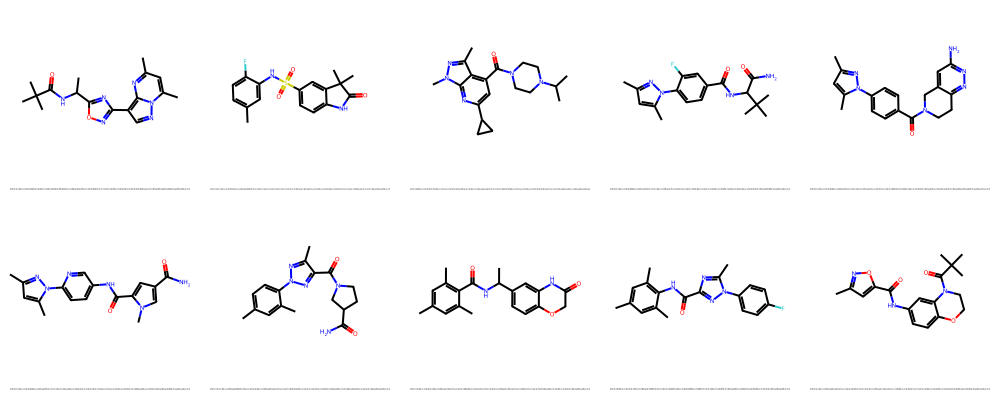

generated data


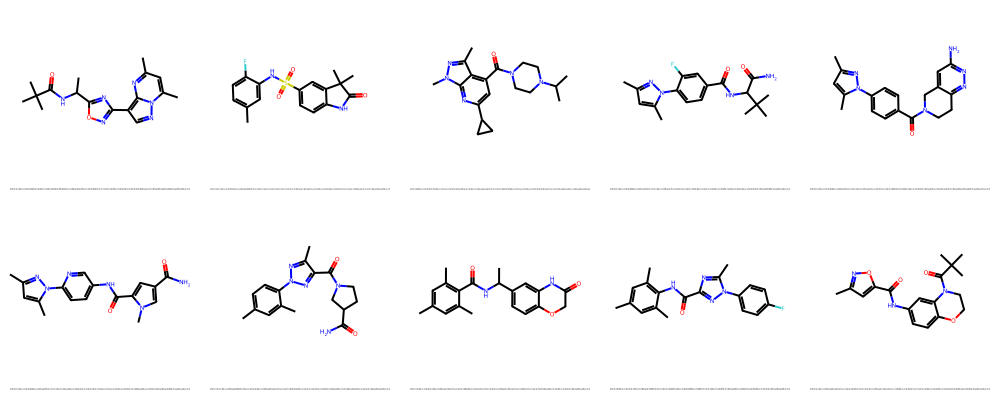

In [92]:
print("original data")
plot_mol(whole_latent_data[(whole_latent_data['tanimoto_sim_bw_original_generated']==1)][:10], 'data')
print("generated data")
plot_mol(whole_latent_data[(whole_latent_data['tanimoto_sim_bw_original_generated']==1)][:10], 'generated')

(array([1.0000e+02, 8.1800e+02, 2.3530e+03, 3.0950e+03, 2.7150e+03,
        2.0780e+03, 1.6850e+03, 1.4120e+03, 1.2580e+03, 1.1820e+03,
        1.0980e+03, 9.5800e+02, 9.2200e+02, 8.2600e+02, 7.3100e+02,
        3.6300e+02, 2.4900e+02, 2.4000e+01, 1.2000e+01, 2.8121e+04]),
 array([0.01123596, 0.06067416, 0.11011236, 0.15955056, 0.20898876,
        0.25842697, 0.30786517, 0.35730337, 0.40674157, 0.45617978,
        0.50561798, 0.55505618, 0.60449438, 0.65393258, 0.70337079,
        0.75280899, 0.80224719, 0.85168539, 0.9011236 , 0.9505618 ,
        1.        ]),
 <BarContainer object of 20 artists>)

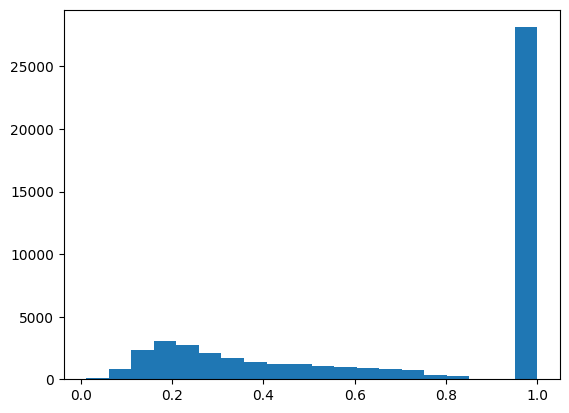

In [43]:
plt.hist(whole_latent_data['tanimoto_sim_bw_original_generated'], bins=20) 

The above plot implies that the 56.2% of whole generated sample might be equal molecule compared to the original molecules
To verify the hypothesis, check equivalence using rdkit.

In [45]:
whole_latent_data.head()

,data,mu,logvar,z,logP,QED,SA,euclid_dist_mu_z,generated,generated_smiles,original_smiles,tanimoto_sim_bw_original_generated
0,[C][C][Branch1][C][C][C][C][C][C][Branch1][C][...,"[0.03904126, 0.054448195, -0.0038935198, 2.195...","[-0.029872973, -0.030340943, -0.050990555, -7....","[0.01951417, 0.05942897, -0.6873364, 2.1770637...",3.53550,0.689672,5.290425,10.026725,[C][C][Branch1][C][C][C][C][C][C][Branch1][C][...,CC1(C)CC2CC(C)(CN2C(=O)C34CCC(C)(C(=O)C3)C4(C)...,CC1(C)CC2CC(C)(CN2C(=O)C34CCC(C)(C(=O)O3)C4(C)...,0.706667
1,[C][C][=N][N][Branch1][C][C][C][=N][C][Branch1...,"[-0.0538008, -0.022801446, 0.068555735, 0.8746...","[-0.02396229, -0.013087352, -0.023507357, -7.5...","[-2.6610525, -0.9655211, 1.6625508, 0.8754231,...",4.04922,0.823506,3.139359,10.520553,[C][C][N][=C][Branch1][C][C][N][Branch2][Ring1...,C=1CN=C(C)N(CCC(O)C(NC(=O)C(C)C)CC)C=1C,CC1=NN(C)C2=NC(C(C)C)=CC(C(=O)N(C3CC3)C(C)C(C)...,0.196078
2,[C][C][C][=C][Branch1][C][C][N][N][=C][C][Bran...,"[-0.036656417, 0.045198087, -0.0326275, -0.799...","[-0.024600118, -0.020833546, -0.016681656, -7....","[-0.56097615, -0.23542279, 0.4594812, -0.79648...",2.61944,0.785452,3.164137,9.909309,[C][C][C][=C][Branch1][C][C][N][N][=C][C][Bran...,CCC1=C(C)NN=CC(C2=NOC(C(=O)N3CCC(C)CC3C)=C2C)=N1,CC=1C=C(C)N2N=CC(C3=NOC(C(C)NC(=O)C(C)(C)C)=N3...,0.206897
3,[C][C][N][=C][Branch1][C][C][N][Branch2][Ring2...,"[-0.06252841, 0.040386297, 0.12026331, 1.01132...","[-0.015464575, -0.00603069, -0.0076016914, -7....","[-0.06892243, 0.10519941, -0.3359178, 1.026771...",2.40324,0.838778,3.188758,10.103575,[C][C][N][=C][Branch2][Ring1][#Branch1][C][C][...,CC=1N=C(CCNC(=O)C2=CC=C3C(=C2)CCC34)SC=1CC5=CC...,CC=1N=C(C)N(C2CCCN(C(=O)C3=CC(C(C)(C)C)=NN3C)C...,0.146154
4,[C][C][C][=C][Branch1][C][C][N][Branch2][Ring2...,"[-0.14229195, 0.022089787, -0.048887838, -0.61...","[-0.018854707, -0.011942884, -0.008654743, -6....","[-0.66296697, -0.021960914, 1.8859369, -0.5528...",3.68894,0.707873,2.177726,9.635033,[C][C][C][=C][Branch1][C][C][N][Branch2][Ring2...,CC=1C=C(C)NCC=C2C=CC(NC(=O)C3=C(C)OCC(=O)N3C)=...,CC=1C=C(C)N(C2=CC=C(C(=O)N(CC3=CC=CC=N3)C4CC4)...,0.158730


In [44]:
def check_mols_equal(mol1_smiles, mol2_smiles):
    mol1 = Chem.MolFromSmiles(mol1_smiles)
    mol2 = Chem.MolFromSmiles(mol2_smiles)
    
    smiles1 = Chem.MolToSmiles(mol1, canonical=True)
    smiles2 = Chem.MolToSmiles(mol2, canonical=True)

    return smiles1 == smiles2

In [49]:
mols_equal = []

for idx in whole_latent_data[whole_latent_data['tanimoto_sim_bw_original_generated']==1].index:
    mols_equal.append(check_mols_equal(whole_latent_data.loc[idx,'original_smiles'], whole_latent_data.loc[idx,'generated_smiles']))

In [52]:
len(mols_equal), sum(mols_equal) #this implies that all taniomoto similarity 1.0 are actually the same molecules.

(28116, 28116)

### Case 1 : For tanimoto equivalent molecule, perform sampling and compare the diversity

In [54]:
test_case1 = whole_latent_data[whole_latent_data['tanimoto_sim_bw_original_generated']==1].iloc[0]

test_case1

data                                  [C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...
mu                                    [-0.056067955, 0.06496021, -0.10714342, -0.354...
logvar                                [-0.015844982, -0.017521413, -0.021635285, -6....
z                                     [-0.29293522, 1.6622334, -0.9517398, -0.344495...
logP                                                                            3.16462
QED                                                                            0.894539
SA                                                                             2.311317
euclid_dist_mu_z                                                              11.583326
generated                             [C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...
generated_smiles                      CC1=CC=C(F)C(NS(=O)(=O)C2=CC=C3C(=C2)C(C)(C)C(...
original_smiles                       CC1=CC=C(F)C(NS(=O)(=O)C2=CC=C3C(=C2)C(C)(C)C(...
tanimoto_sim_bw_original_generat

In [140]:
z_test1, samples_test1 = sampling_for_fixed_single_mu(model_prp, test_case1['mu'], test_case1['logvar'], 1000)

In [141]:
samples_test1[:5]

['[C][C][=C][C][=C][Branch1][C][F][C][Branch2][Ring1][#C][N][N][=N][C][Branch2][Ring1][C][C][C][Branch1][C][O][C][Branch1][C][O][C][Branch1][C][C][Branch1][C][C][O][=C][Ring1][#C][C][Ring2][Ring1][C][=C][Ring2][Ring1][#Branch1]',
 '[C][C][=C][C][=C][Branch1][C][F][C][Branch2][Ring1][#C][N][N][Branch2][Ring1][Ring2][C][=Branch1][C][=O][C][=C][C][=C][C][Branch1][=Branch1][C][Branch1][C][C][=O][=C][Ring1][=Branch2][C][=Branch1][C][=O][C][Ring1][S][=C][Ring2][Ring1][#Branch1]',
 '[C][C][=C][C][=C][Branch1][C][F][C][Branch2][Ring1][#C][N][N][Branch2][Ring1][Ring2][C][=Branch1][C][=O][C][=C][C][=C][C][Branch1][=Branch1][C][Branch1][C][N][=O][=C][Ring1][=Branch2][C][C][C][C][Ring1][Ring1][=C][Ring2][Ring1][Branch2]',
 '[C][C][=C][C][=C][Branch1][C][F][C][Branch2][Ring1][#C][N][N][Branch2][Ring1][Ring2][C][C][=Branch1][C][=O][O][C][=C][Branch1][C][C][C][=C][C][=C][Ring1][#Branch1][C][C][=Branch1][C][=O][NH1][Ring2][Ring1][#Branch1]',
 '[C][C][=C][C][=C][Branch1][C][F][C][Branch2][Ring1][#C][N]

### for samples from test 1

In [142]:
tn_sim = [calculate_tanomoto_similiarity(test_case1['original_smiles'], sf.decoder(s)) for s in samples_test1]

(array([ 52., 198., 288.,  63.,  42., 106.,  42.,   1.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 206.]),
 array([0.04065041, 0.08861789, 0.13658537, 0.18455285, 0.23252033,
        0.2804878 , 0.32845528, 0.37642276, 0.42439024, 0.47235772,
        0.5203252 , 0.56829268, 0.61626016, 0.66422764, 0.71219512,
        0.7601626 , 0.80813008, 0.85609756, 0.90406504, 0.95203252,
        1.        ]),
 <BarContainer object of 20 artists>)

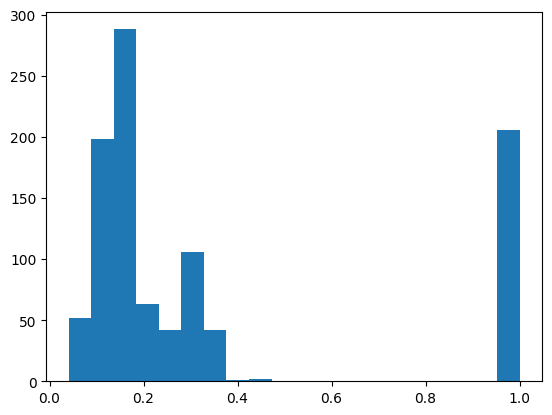

In [143]:
plt.hist(tn_sim, bins=20) # about 206/1000 ~ 0.206 are the same as the original molecule.

### distance distribution for the molecules

In [144]:
euclid_dist = [np.sqrt(sum((test_case1['mu'] - z.numpy())**2)) for z in z_test1]

(array([  2.,   7.,  13.,  14.,  40.,  65.,  92., 121., 125., 107., 106.,
        102.,  78.,  61.,  31.,  23.,   6.,   3.,   3.,   1.]),
 array([ 8.60968301,  8.83058175,  9.05148049,  9.27237922,  9.49327796,
         9.7141767 ,  9.93507544, 10.15597417, 10.37687291, 10.59777165,
        10.81867039, 11.03956913, 11.26046786, 11.4813666 , 11.70226534,
        11.92316408, 12.14406281, 12.36496155, 12.58586029, 12.80675903,
        13.02765777]),
 <BarContainer object of 20 artists>)

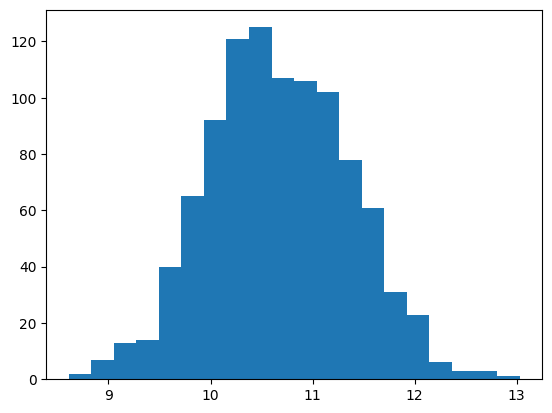

In [145]:
plt.hist(euclid_dist, bins=20) # about 65/400 ~ 0.16 are the same as the original molecule.

Text(0.5, 1.0, 'euclid distance vs tanimoto similarity')

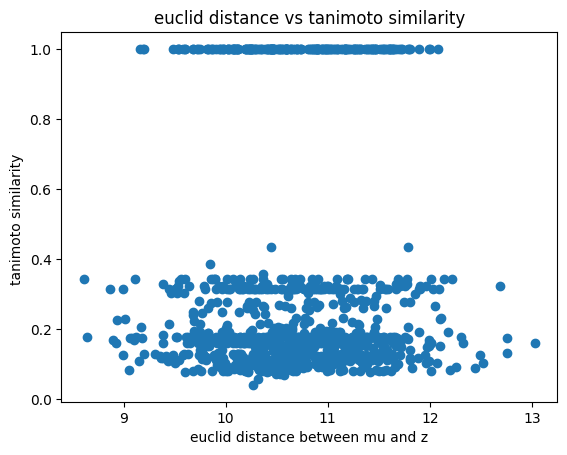

In [146]:
plt.scatter(euclid_dist, tn_sim)
plt.xlabel('euclid distance between mu and z')
plt.ylabel('tanimoto similarity ')
plt.title('euclid distance vs tanimoto similarity')

### properties for newly generated molecules calculated by utilizing rdkit

In [147]:
def cal_props(samples):
    # samples : list of SELFIES
    samples_mol = [Chem.MolFromSmiles(sf.decoder(s)) for s in samples]
    qed = [QED(mol) for mol in samples_mol]
    logp = [logP(mol) for mol in samples_mol]
    sa = [SA(mol) for mol in samples_mol]
    
    prop_df = pd.DataFrame({'QED': qed, 'logP': logp, 'SA': sa})

    return prop_df

In [148]:
prop_df = cal_props(samples_test1)

prop_df.head()

,QED,logP,SA
0,0.426727,2.42700,4.963679
1,0.642729,2.74072,2.576760
2,0.792852,3.11232,2.453602
3,0.247999,2.85532,3.528524
4,0.356844,2.99782,3.967530


In [149]:
real_prop = test_case1[['QED', 'logP', 'SA']]

In [150]:
real_prop

QED     0.894539
logP     3.16462
SA      2.311317
Name: 7, dtype: object

In [151]:
prop_df['tn_sim'] = tn_sim
prop_df['euclid_dist'] = euclid_dist

In [152]:
prop_df.head()

,QED,logP,SA,tn_sim,euclid_dist
0,0.426727,2.42700,4.963679,0.104348,9.506913
1,0.642729,2.74072,2.576760,0.323232,10.732299
2,0.792852,3.11232,2.453602,0.313725,8.989240
3,0.247999,2.85532,3.528524,0.139130,9.751085
4,0.356844,2.99782,3.967530,0.207207,10.508106


In [153]:
#### calculate the difference between the real properties and the generated properties

prop_df['QED_diff'] = prop_df['QED'] - real_prop['QED']
prop_df['logP_diff'] = prop_df['logP'] - real_prop['logP']
prop_df['SA_diff'] = prop_df['SA'] - real_prop['SA']

In [154]:
def plot_prop_diff(prop_df, prop_type=['QED_diff', 'logP_diff', 'SA_diff'], metric='euclid_dist'):
    fig, ax = plt.subplots(1, len(prop_type), figsize=(15, 5))

    for i, prop in enumerate(prop_type):
        ax[i].scatter(prop_df[metric], prop_df[prop])
        ax[i].set_xlabel(metric)
        ax[i].set_ylabel(prop)
        ax[i].set_title(f'{prop} vs {metric}')

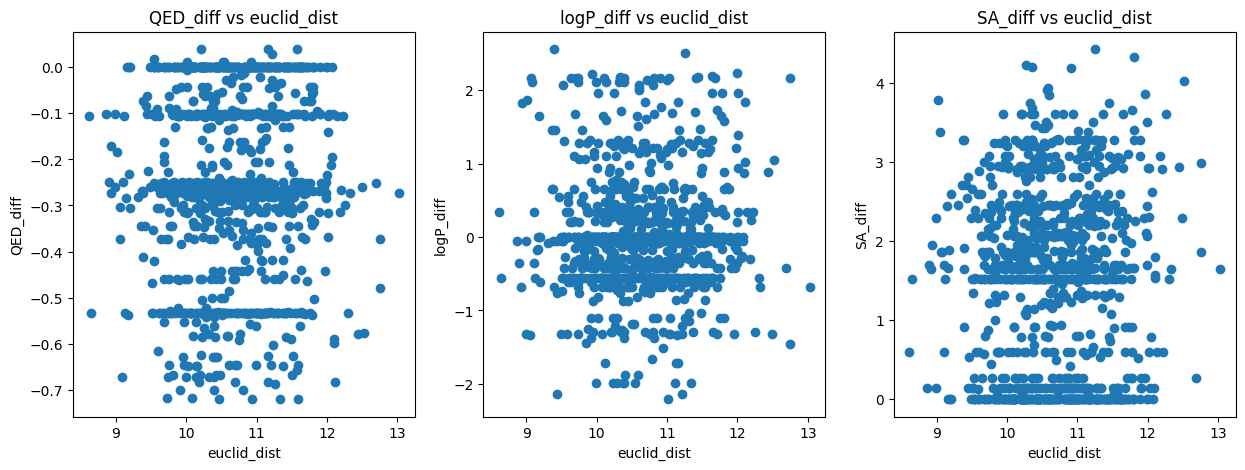

In [155]:
plot_prop_diff(prop_df)

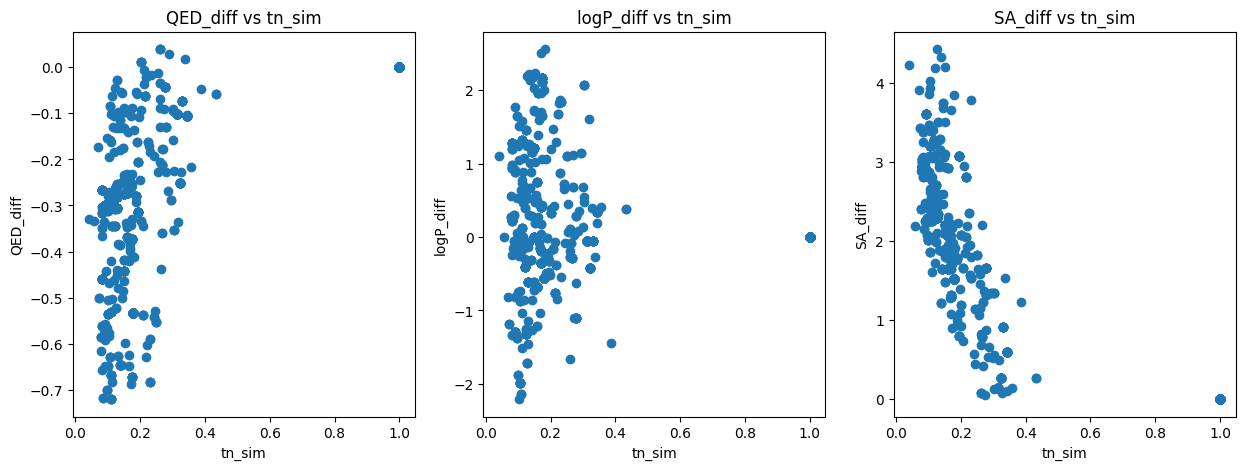

In [156]:
## plot the difference between the real properties and the generated properties comparing euclidean distance

plot_prop_diff(prop_df, metric='tn_sim')

In [186]:
prop_df['sample'] = samples_test1

In [187]:
prop_df.head()

,QED,logP,SA,tn_sim,euclid_dist,QED_diff,logP_diff,SA_diff,sample
0,0.426727,2.42700,4.963679,0.104348,9.506913,-0.467811,-0.73762,2.652362,[C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...
1,0.642729,2.74072,2.576760,0.323232,10.732299,-0.251810,-0.42390,0.265443,[C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...
2,0.792852,3.11232,2.453602,0.313725,8.989240,-0.101686,-0.05230,0.142285,[C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...
3,0.247999,2.85532,3.528524,0.139130,9.751085,-0.646540,-0.30930,1.217207,[C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...
4,0.356844,2.99782,3.967530,0.207207,10.508106,-0.537694,-0.16680,1.656213,[C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...


In [188]:
#analysis of the latent space that generates the same molecule as mu

same_df = prop_df[prop_df['tn_sim']==1]

In [190]:
same_df.sort_values('euclid_dist', ascending=True)

,QED,logP,SA,tn_sim,euclid_dist,QED_diff,logP_diff,SA_diff,sample
683,0.894539,3.16462,2.311317,1.0,9.160862,1.387588e-08,7.736206e-08,9.560236e-08,[C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...
81,0.894539,3.16462,2.311317,1.0,9.186855,1.387588e-08,7.736206e-08,9.560236e-08,[C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...
246,0.894539,3.16462,2.311317,1.0,9.197471,1.387588e-08,7.736206e-08,9.560236e-08,[C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...
340,0.894539,3.16462,2.311317,1.0,9.486727,1.387588e-08,7.736206e-08,9.560236e-08,[C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...
721,0.894539,3.16462,2.311317,1.0,9.534218,1.387588e-08,7.736206e-08,9.560236e-08,[C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...
...,...,...,...,...,...,...,...,...,...
730,0.894539,3.16462,2.311317,1.0,11.808460,1.387588e-08,7.736206e-08,9.560236e-08,[C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...
802,0.894539,3.16462,2.311317,1.0,11.893973,1.387588e-08,7.736206e-08,9.560236e-08,[C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...
297,0.894539,3.16462,2.311317,1.0,11.990920,1.387588e-08,7.736206e-08,9.560236e-08,[C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...
90,0.894539,3.16462,2.311317,1.0,12.003662,1.387588e-08,7.736206e-08,9.560236e-08,[C][C][=C][C][=C][Branch1][C][F][C][Branch2][R...


array([[<Axes: title={'center': 'euclid_dist'}>]], dtype=object)

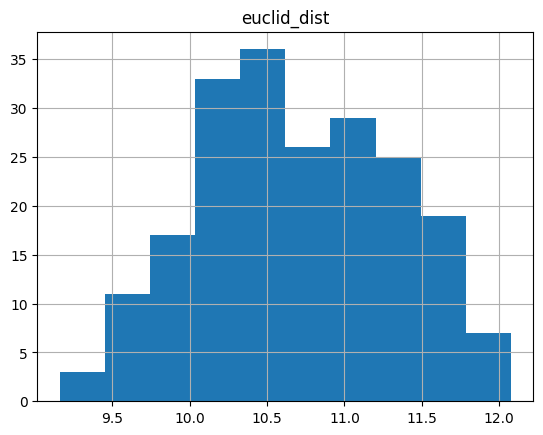

In [191]:
same_df.hist('euclid_dist')

## Test 2 : other molecules

In [157]:
test_case2 = whole_latent_data[whole_latent_data['tanimoto_sim_bw_original_generated']!=1].iloc[0]

In [158]:
test_case2

data                                  [C][C][Branch1][C][C][C][C][C][C][Branch1][C][...
mu                                    [0.03904126, 0.054448195, -0.0038935198, 2.195...
logvar                                [-0.029872973, -0.030340943, -0.050990555, -7....
z                                     [0.01951417, 0.05942897, -0.6873364, 2.1770637...
logP                                                                             3.5355
QED                                                                            0.689672
SA                                                                             5.290425
euclid_dist_mu_z                                                              10.026725
generated                             [C][C][Branch1][C][C][C][C][C][C][Branch1][C][...
generated_smiles                      CC1(C)CC2CC(C)(CN2C(=O)C34CCC(C)(C(=O)C3)C4(C)...
original_smiles                       CC1(C)CC2CC(C)(CN2C(=O)C34CCC(C)(C(=O)O3)C4(C)...
tanimoto_sim_bw_original_generat

In [159]:
check_mols_equal(test_case2['original_smiles'], test_case2['generated_smiles']) #original molecule and generated molecule is different

False

In [160]:
z_test2, samples_test2 = sampling_for_fixed_single_mu(model_prp, test_case2['mu'], test_case2['logvar'], 1000)

In [161]:
tn_sim2 = [calculate_tanomoto_similiarity(test_case2['original_smiles'], sf.decoder(s)) for s in samples_test2]

(array([  9., 225., 197., 108.,  56.,   3.,   1.,   0.,   5.,   8.,   0.,
          0.,   0.,  25.,   0.,   0.,   0.,   0.,   0., 363.]),
 array([0.10569106, 0.1504065 , 0.19512195, 0.2398374 , 0.28455285,
        0.32926829, 0.37398374, 0.41869919, 0.46341463, 0.50813008,
        0.55284553, 0.59756098, 0.64227642, 0.68699187, 0.73170732,
        0.77642276, 0.82113821, 0.86585366, 0.91056911, 0.95528455,
        1.        ]),
 <BarContainer object of 20 artists>)

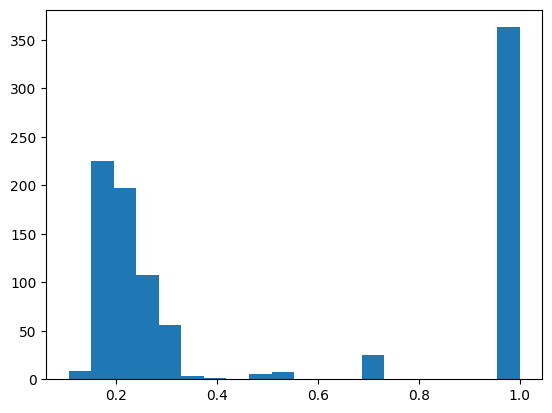

In [163]:
plt.hist(tn_sim2, bins=20) # about 363/1000 ~ 0.36 are the same as the original molecule.

In [164]:
count = 0
for idx in range(len(samples_test2)):
    s = samples_test2[idx]

    if check_mols_equal(test_case2['original_smiles'], sf.decoder(s)) and tn_sim2[idx]==1:
        count += 1

In [165]:
count # then then number of molecules that has same tanimoto 

363

In [166]:
euclid_dist2 = [np.sqrt(sum((test_case2['mu'] - z.numpy())**2)) for z in z_test2]

(array([  1.,   1.,   5.,  17.,  28.,  56.,  82.,  91., 122., 137., 119.,
        104.,  91.,  50.,  47.,  25.,  11.,   8.,   4.,   1.]),
 array([ 8.35328629,  8.58210653,  8.81092676,  9.039747  ,  9.26856724,
         9.49738748,  9.72620771,  9.95502795, 10.18384819, 10.41266842,
        10.64148866, 10.8703089 , 11.09912914, 11.32794937, 11.55676961,
        11.78558985, 12.01441009, 12.24323032, 12.47205056, 12.7008708 ,
        12.92969104]),
 <BarContainer object of 20 artists>)

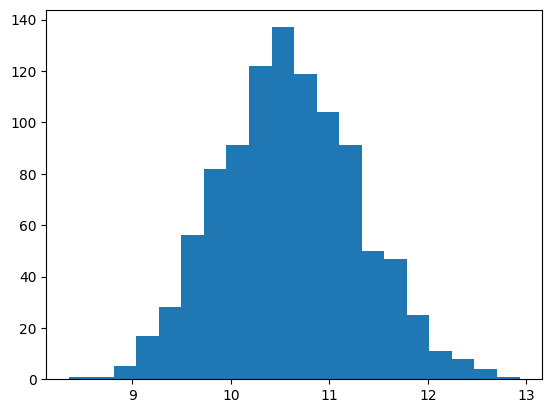

In [167]:
plt.hist(euclid_dist2, bins=20) # about 65/400 ~ 0.16 are the same as the original molecule.

Text(0.5, 1.0, 'euclid distance vs tanimoto similarity')

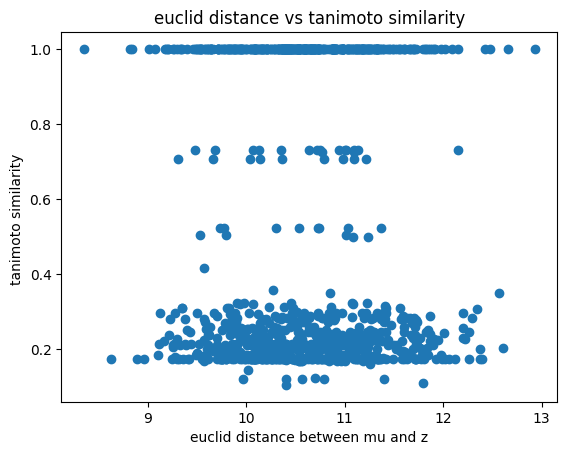

In [168]:
plt.scatter(euclid_dist2, tn_sim2)
plt.xlabel('euclid distance between mu and z')
plt.ylabel('tanimoto similarity ')
plt.title('euclid distance vs tanimoto similarity')

In [169]:
prop_df2 = cal_props(samples_test2)

prop_df2.head()

,QED,logP,SA
0,0.689672,3.53550,5.290425
1,0.677633,3.72050,5.154872
2,0.689672,3.53550,5.290425
3,0.634194,4.70638,3.456880
4,0.689672,3.53550,5.290425


In [170]:
real_prop = test_case2[['QED', 'logP', 'SA']]

In [171]:
prop_df2['tn_sim'] = tn_sim2
prop_df2['euclid_dist'] = euclid_dist2

In [172]:
prop_df2['QED_diff'] = prop_df2['QED'] - real_prop['QED']
prop_df2['logP_diff'] = prop_df2['logP'] - real_prop['logP']
prop_df2['SA_diff'] = prop_df2['SA'] - real_prop['SA']

In [173]:
prop_df2.head()

,QED,logP,SA,tn_sim,euclid_dist,QED_diff,logP_diff,SA_diff
0,0.689672,3.53550,5.290425,1.000000,11.023621,-2.314338e-08,-4.959106e-08,-8.075454e-08
1,0.677633,3.72050,5.154872,0.203704,10.094711,-1.203888e-02,1.850000e-01,-1.355538e-01
2,0.689672,3.53550,5.290425,1.000000,11.548332,-2.314338e-08,-4.959106e-08,-8.075454e-08
3,0.634194,4.70638,3.456880,0.112000,11.794389,-5.547770e-02,1.170880e+00,-1.833546e+00
4,0.689672,3.53550,5.290425,1.000000,11.198903,-2.314338e-08,-4.959106e-08,-8.075454e-08


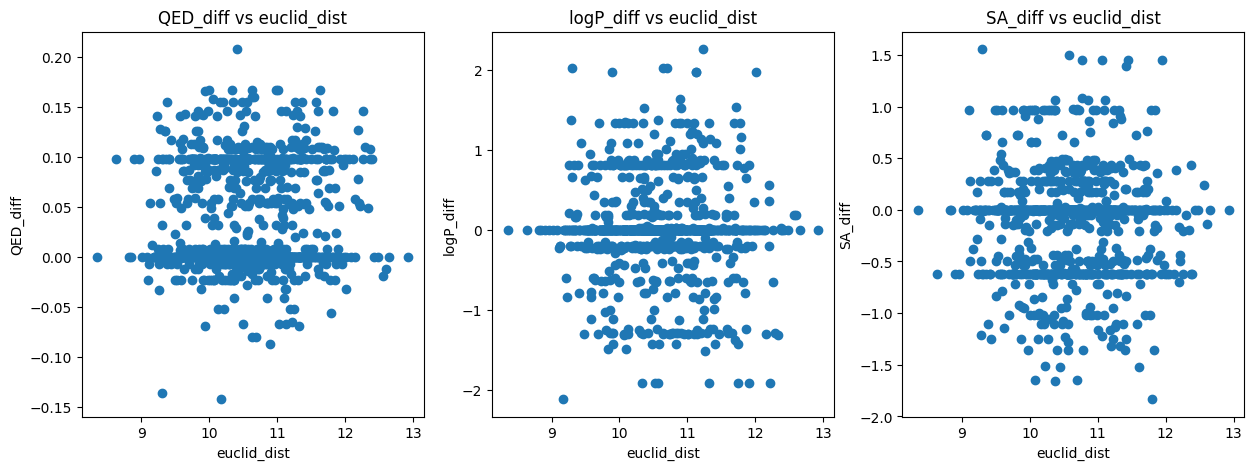

In [174]:
plot_prop_diff(prop_df2)

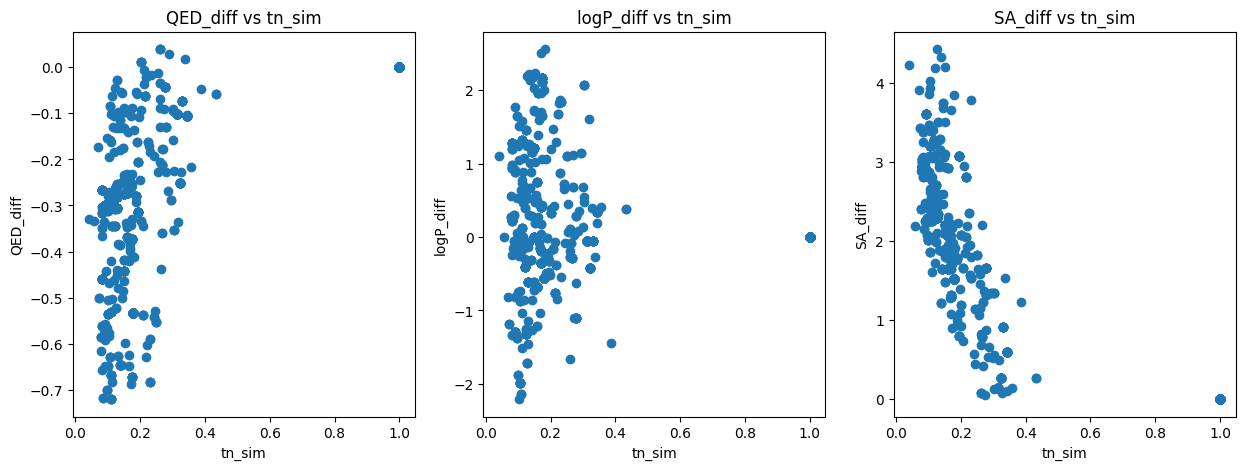

In [175]:
plot_prop_diff(prop_df, metric='tn_sim')

## Calculate average novelty of each molecules when generating 1000 molecules from the molecules.

In [203]:
def cal_novelty(model, idx_mol, n_gen=1000):
    """function for calculating the novelty of the generated molecules from the fixed mu value.

    Args:
        model (pytorch model): vae model
        idx_mol (pd.Series): each row of whole dataframe
        n_gen (int, optional): number of molecules to be generated from mu. Defaults to 1000.

    Returns:
        novelty_list(list) : list of novelty values
    """
    z, samples = sampling_for_fixed_single_mu(model, idx_mol['mu'], idx_mol['logvar'], n_gen)
    tn_sim = [calculate_tanomoto_similiarity(idx_mol['original_smiles'], sf.decoder(s)) for s in samples]

    novelty = 1 - sum([1 for sim in tn_sim if sim==1])/n_gen

    return novelty

In [204]:
avg_novelty = []

In [208]:
from tqdm import tqdm

# Assuming you have a list of indices called 'indices'
for idx in tqdm(np.random.choice(whole_latent_data.index, 1000, replace=False)):
    idx_mol = whole_latent_data.loc[idx,:]
    avg_novelty.append(cal_novelty(model_prp, idx_mol, n_gen=1000))

100%|██████████| 1000/1000 [35:31<00:00,  2.13s/it]


In [209]:
sum(avg_novelty)/len(avg_novelty)

0.3683377483443712

So among 50000 molecules, 1000 molecules are selected and checked the novelty, the novel ratio of generated molecules.

The result is about 36.8%.

### directional analysis for the same molecule's latent vector representation

In [211]:
import itertools

In [249]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def cal_cosine_range(samples_test1, test_case1):
    # mols = samples_test1.numpy() - test_case1['mu']

    # cos_sim = [cosine_similarity(mol1, mol2) for mol1, mol2 in itertools.combinations(mols,2)]
    cos_sim = [cosine_similarity(test_case1['mu'], z.numpy()) for z in samples_test1]
    return cos_sim
    

In [250]:
equal_z = z_test1[same_df.index]

In [251]:
cos_sim_eq = cal_cosine_range(equal_z, test_case1)

Tested cosine similarity for the molecules that have 

In [252]:
print(len(equal_z))

206


Text(0.5, 1.0, 'distirbution of cosine similarity between latent vector that generate the same molecule and mu')

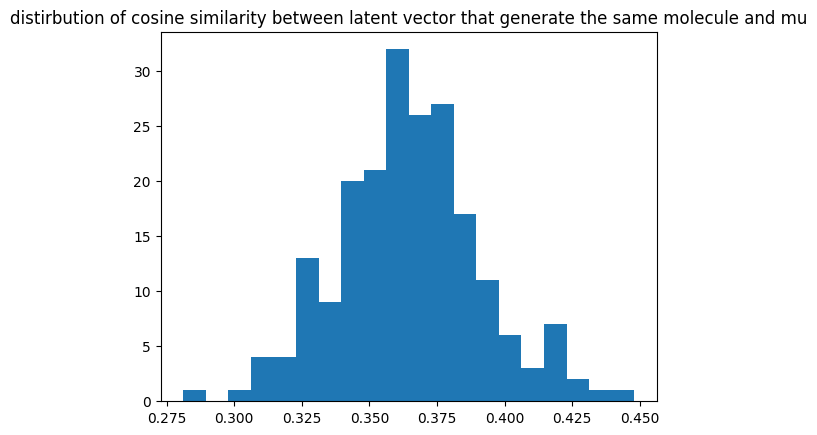

In [256]:
plt.hist(cos_sim_eq, bins=20)
plt.title('distirbution of cosine similarity between latent vector that generate the same molecule and mu')

In [257]:
cos_sim_all = cal_cosine_range(z_test1, test_case1)

Text(0.5, 1.0, 'distirbution of cosine similarity between all latent vector with mu')

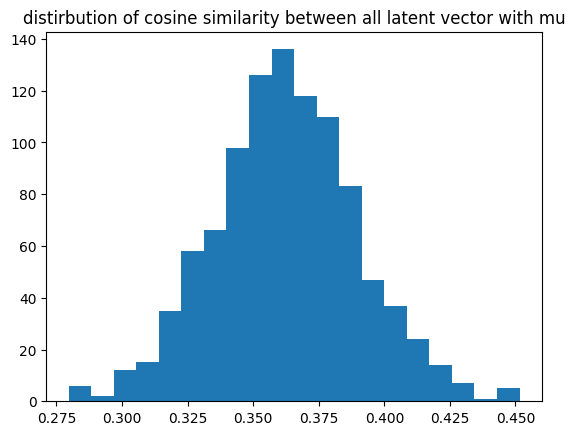

In [258]:
plt.hist(cos_sim_all, bins=20)
plt.title('distirbution of cosine similarity between all latent vector with mu')

# 3. print interpolated molecule structure

In [ ]:
def lin_interp(x,y,t):
    '''
    x: starting point
    y: ending point
    t: interpolation parameter
    '''
    return t*y + (1-t)*x

In [ ]:
def slerp(low, high, val):
    '''
    low: starting point
    high: ending point
    val: interpolation parameter between 0 and 1
    '''
    omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high

In [ ]:
def print_interp(start, end, n, type='slerp', test=True):
    '''
    i: index of the first molecule
    j: index of the second molecule
    n: number of interpolation points
    type: interpolation type, either 'slerp' or 'linear'
    '''
    start = start
    end = end
    t_vals = np.linspace(0, 1, n)
    if type == 'slerp':
        interps = [slerp(start, end, t) for t in t_vals]
    else:
        interps = [lin_interp(start, end, t) for t in t_vals]
    interps = np.array(interps)
    interps_torch = torch.from_numpy(interps)
    interps_torch = torch.tensor(interps_torch, dtype=torch.float32)

    model.eval()
    print(interps_torch.shape)
    #sampled, new_x = model.sample(n, z=torch.from_numpy(np.zeros((8, 128), dtype=np.float32)), test=True) 
    sampled = model.sample(n, z=interps_torch, temp=1.0, test=test)

    sampled_df = pd.DataFrame(sampled, columns=['SMILES'])
    sampled_df['Romol'] = sampled_df['SMILES'].apply(Chem.MolFromSmiles)
    display(PandasTools.FrameToGridImage(sampled_df, column='Romol', legendsCol='SMILES', molsPerRow=4))
    print(f'sample length: {len(sampled_df)}')

    return interps, sampled_df

## 3.1. Intepolation by selecting random molecules
select random molescule --> encode --> interpolate in latent space --> decode

In [ ]:
config = torch.load('../../NewMoses_results/ZINC_vae_20240515/vae_config.pt')

# vocab = torch.load('../checkpoints/ZINC_vae_done/vae_vocab.pt')

train = moses.get_dataset('train', config)
vocab = CharVocab.from_data(train)
vocab.vectors = torch.eye(len(vocab.c2i))

model_path = '../../NewMoses_results/ZINC_vae_20240515/vae_model_060.pt'

model = VAE(vocab, config)
model.load_state_dict(torch.load(model_path))

In [ ]:
traindata_path = '../moses/dataset/data/ZINC/train.csv'
train_molecule = pd.read_csv(traindata_path)
n = 100
selected_mol = train_molecule.sample(n=n)[['SMILES']]
#selected_gen['ROMol'] = selected_gen['SMILES'].apply(Chem.MolFromSmiles)
selected_mol = selected_mol.reset_index(drop=True)
selected_mol

In [ ]:
selected_smiles = np.array(selected_mol['SMILES'].tolist())


In [ ]:
from torch.utils.data import DataLoader

selected_dataset = StringDataset(vocab, selected_smiles)
selected_dataloader = DataLoader(
    selected_dataset, batch_size=n,
    shuffle=False, collate_fn=selected_dataset.default_collate
)
for i, batch in enumerate(selected_dataloader):
    mu, z, _ = model.forward_encoder(batch[0].T)
    if i == 0:
        Z = torch.empty((0, z.shape[1]))
        MU = torch.empty((0, mu.shape[1]))
    # do pca and normalize
    Z = torch.cat((Z, z), dim=0)
    MU = torch.cat((MU, mu), dim=0)
    
Z = Z.detach().numpy()
MU = MU.detach().numpy()
sampled_Z = Z
sampled_MU = MU

In [ ]:
sampled_batch = batch[0].transpose(0,1)

In [ ]:
selected_mol['RoMol'] = selected_mol['SMILES'].apply(Chem.MolFromSmiles)
display(PandasTools.FrameToGridImage(selected_mol[:2], column='RoMol', legendsCol='SMILES', molsPerRow=5))

In [ ]:
slerp_emb, sampled_df_slerp = print_interp(sampled_MU[0], sampled_MU[4], 8, type='slerp', test=True)
slerp_emb, sampled_df_slerp = print_interp(sampled_Z[0], sampled_Z[4], 8, type='slerp', test=True) #real vs sample

slerp_emb, sampled_df_lin = print_interp(sampled_MU[0], sampled_MU[1], 8, type='linear', test=True) #slerp vs linear
slerp_emb, sampled_df_rand = print_interp(sampled_MU[0], sampled_MU[1], 8, type='slerp', test=False)

In [ ]:
slerp_emb, sampled_df_slerp = print_interp(sampled_Z[0], sampled_Z[1], 8, type='slerp', test=True)
slerp_emb, y_lin, sampled_df_lin = print_interp(sampled_Z[0], sampled_Z[1], 8, type='linear', test=True)
slerp_emb, y_rand, sampled_df_rand = print_interp(sampled_Z[0], sampled_Z[1], 8, type='slerp', test=False) #multinomial sampling 

## 3.2. Interpolation by PCA inverse

In [ ]:
folder_path = '../../NewMoses_results/ZINC_vae_20240515/'
config_file = 'vae_config.pt'
model_file = 'vae_model_080.pt'

train, config, model = get_vae_model(folder_path, config_file, model_file)
sample = get_sample(train, None)
Z = get_Z(config, model, sample)

In [ ]:
pca = PCA(n_components=2)
pca_Z = pca.fit_transform(Z)
scaler = MinMaxScaler()
scaled_Z = scaler.fit_transform(pca_Z)

#plot_emb(scaled_Z, sample_prop, ['QED'], 'ZINC', 'PCA')

In [ ]:
sample_point = np.array([[0.0, 0.5],[1.0, 0.65]] )


In [ ]:
undo_scale = scaler.inverse_transform(sample_point)
recon_sample = pca.inverse_transform(undo_scale)

In [ ]:
slerp_emb, y1, sampled_df1 = print_interp(recon_sample[0], recon_sample[1], 8, type='slerp', test=True)
slerp_emb, y2, sampled_df2 = print_interp(recon_sample[0], recon_sample[1], 8, type='linear', test=True)
slerp_emb, y3, sampled_df3 = print_interp(recon_sample[0], recon_sample[1], 8, type='slerp', test=False)


## 3.3 Similarity check

In [ ]:
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect as Morgan
from rdkit import DataStructs

In [ ]:
fpgen = AllChem.GetRDKitFPGenerator()
fps = [fpgen.GetFingerprint(x) for x in sampled_df_lin['Romol']]
DataStructs.TanimotoSimilarity(fps[0],fps[1])

In [ ]:
# get tanimoto similarity between fps[0] and fps[1]
# without using datastructs
def calc_simi(df_romol):
    fpgen = AllChem.GetRDKitFPGenerator()
    fps = [fpgen.GetFingerprint(x) for x in df_romol]

    similarities = []
    for i in range(len(fps)-1):
        similarity = DataStructs.TanimotoSimilarity(fps[i],fps[i+1])
        similarities.append(similarity)

    return similarities


In [ ]:
simi_lin = calc_simi(sampled_df_lin['Romol'])
simi_slerp = calc_simi(sampled_df_slerp['Romol'])
simi_rand = calc_simi(sampled_df_rand['Romol'])

In [ ]:
print(simi_lin)
print(simi_slerp)
print(simi_rand)

In [ ]:
# plot simi_lin, simi_slerp, simi_rand
plt.figure(figsize=(12,8))
plt.plot(simi_lin, label='linear')
plt.plot(simi_slerp, label='slerp')
plt.plot(simi_rand, label='random')
plt.legend()
plt.show()